<a href="https://colab.research.google.com/github/KhosraviBioinformatics/Feature-selection-random-forest/blob/main/FeatureSelection%26UsingInModels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
install.packages("e1071")
install.packages("caret")
install.packages("randomForest")


library(e1071)
library(caret)
library(randomForest)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘proxy’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘shape’, ‘future.apply’, ‘numDeriv’, ‘progressr’, ‘SQUAREM’, ‘diagram’, ‘lava’, ‘prodlim’, ‘iterators’, ‘clock’, ‘gower’, ‘hardhat’, ‘ipred’, ‘sparsevctrs’, ‘timeDate’, ‘foreach’, ‘ModelMetrics’, ‘plyr’, ‘pROC’, ‘recipes’, ‘reshape2’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: ggplot2

Loading required package: lattice

randomForest 4.7-1.2

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:ggplot2’:

    margin




In [ ]:
install.packages("ggplot2")
library(ggplot2)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
data <- read.csv('/content/data_reordered.csv')

data_t <- t(data)
colnames(data_t)<-data_t[1,]
data_t<-data_t[-1,]

data_t_df <- as.data.frame(data_t)

data_t_df$Stage <- ifelse(grepl("To", rownames(data_t_df)), "one",
                     ifelse(grepl("Tt", rownames(data_t_df)), "two", NA))

table(data_t_df$Stage)

colnames(data_t_df) <- make.names(colnames(data_t_df))


one two 
246 190 

In [ ]:
#convert stage column values to factor
data_t_df$Stage <- as.factor(data_t_df$Stage)

# **Feature Slection with Random Forest:**

In [ ]:
# train & test
set.seed(123)
splitIndex <- createDataPartition(data_t_df$Stage, p = 0.7, list = FALSE)
train_data <- data_t_df[splitIndex, ]
test_data <- data_t_df[-splitIndex, ]

# train RF on feature selected
rf_fs <- randomForest(Stage ~ ., data = train_data, importance = TRUE)


In [ ]:
print(rf_fs)


Call:
 randomForest(formula = Stage ~ ., data = train_data, importance = TRUE) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 113

        OOB estimate of  error rate: 3.59%
Confusion matrix:
    one two class.error
one 170   3  0.01734104
two   8 125  0.06015038


**Selected features:**

In [ ]:
#get and save the all top features
importance_values <- importance(rf_fs)
all_top_feature_table <- as.data.frame(importance_values[order(importance_values[, "MeanDecreaseAccuracy"], decreasing = TRUE), ])

top_features <- rownames(all_top_feature_table)

write.csv(data.frame(Feature = top_features), "AllTopFeaturesByACC.csv", row.names = FALSE)

agg_record_694186118 
                   2

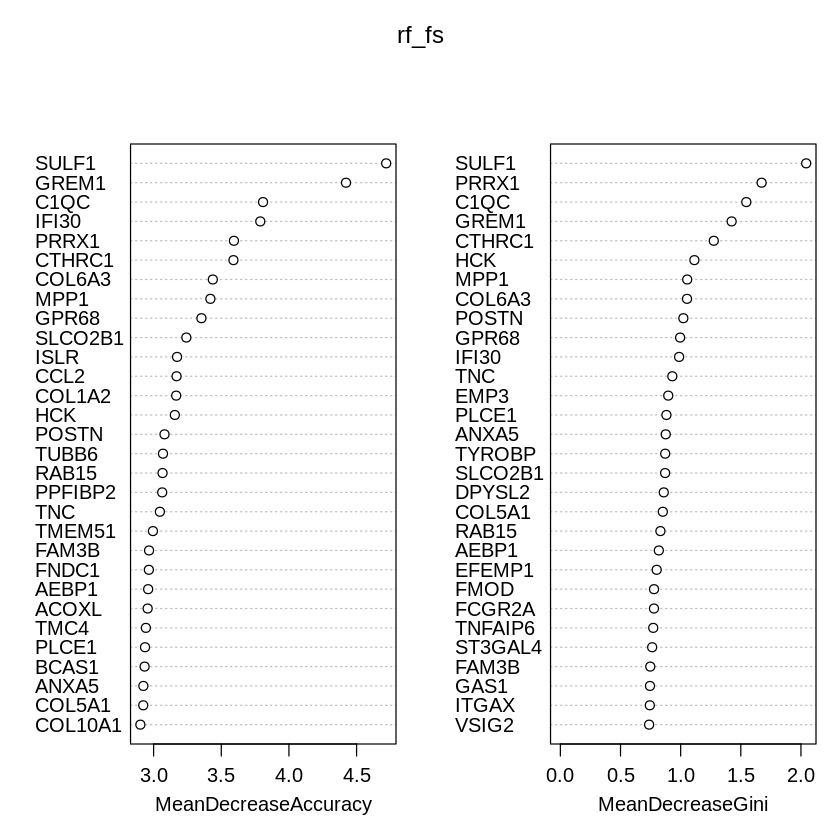

In [ ]:
# Open a PNG device
png("rf_feature_importance_plot.png",  width = 3000, height = 3000,res = 300)

# Generate the plot
varImpPlot(rf_fs)

# Close the device
dev.off()

varImpPlot(rf_fs)

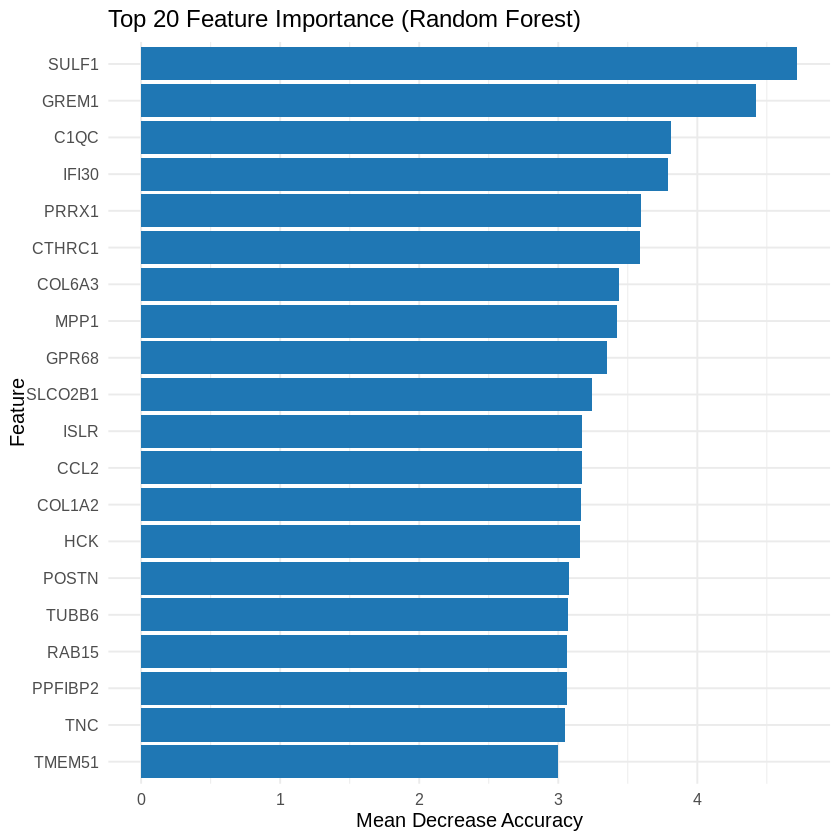

In [ ]:

importance_df <- as.data.frame(importance(rf_fs))
importance_df$Feature <- rownames(importance_df)

importance_df <- importance_df[order(importance_df$MeanDecreaseAccuracy, decreasing = TRUE), ]

top_imp <- importance_df[1:20, ]

p <- ggplot(top_imp, aes(x = reorder(Feature, MeanDecreaseAccuracy), y = MeanDecreaseAccuracy)) +
  geom_bar(stat = "identity", fill = "#1f77b4") +
  coord_flip() +
  labs(title = "Top 20 Feature Importance (Random Forest)",
       x = "Feature",
       y = "Mean Decrease Accuracy") +
  theme_minimal(base_size = 12)

print(p)



In [ ]:
#Save as PNG
ggsave("RF_FeatureImportance.png", plot = p, width = 8, height = 6, dpi = 300)

# **Build & Comparing modles:**

**make test & train dataset based on  the top 20 features:**

In [ ]:
#get and save the top 20 features
top_20_features <- rownames(all_top_feature_table)[1:20]

In [ ]:
#convert test& train data of each columnto numeric
feature_cols <- setdiff(colnames(train_data), "Stage")
for (col in feature_cols) {
  train_data[[col]] <- as.numeric(as.character(train_data[[col]]))
  test_data[[col]]  <- as.numeric(as.character(test_data[[col]]))
}

# build dataset with top 20 features
train_top <- train_data[, c(top_20_features, "Stage")]
test_top  <- test_data[,  c(top_20_features, "Stage")]

**Train models with top features:**

In [ ]:
#  svm with top features
svm_model_top <- svm(Stage ~ ., data = train_top, kernel = "radial", scale = TRUE)
svm_pred_top <- predict(svm_model_top, newdata = test_top)
svm_acc_top <- mean(svm_pred_top == test_top$Stage)

In [ ]:

#  RF with top features
rf_model_top <- randomForest(Stage ~ ., data = train_top)
rf_pred_top <- predict(rf_model_top, newdata = test_top)
rf_acc_top <- mean(rf_pred_top == test_top$Stage)

**Train models with all features:**

In [ ]:
#  svm with all features
svm_model_all <- svm(Stage ~ ., data = train_data, kernel = "radial", scale = TRUE)
svm_pred_all <- predict(svm_model_all, newdata = test_data)
svm_acc_all <- mean(svm_pred_all == test_data$Stage)

In [ ]:
#  RF with all features
rf_model_all <- randomForest(Stage ~ ., data = train_data)
rf_pred_all <- predict(rf_model_all, newdata = test_data)
rf_acc_all <- mean(rf_pred_all == test_data$Stage)

# **Results:**

In [ ]:
# Results table
acc_table <- data.frame(
  Model = c("SVM (top features)", "RF (top features)", "SVM (all features)", "RF (all features)"),
  Accuracy = c(svm_acc_top, rf_acc_top, svm_acc_all, rf_acc_all)
)

print(acc_table)

               Model  Accuracy
1 SVM (top features) 0.9538462
2  RF (top features) 0.9384615
3 SVM (all features) 0.9538462
4  RF (all features) 0.9692308


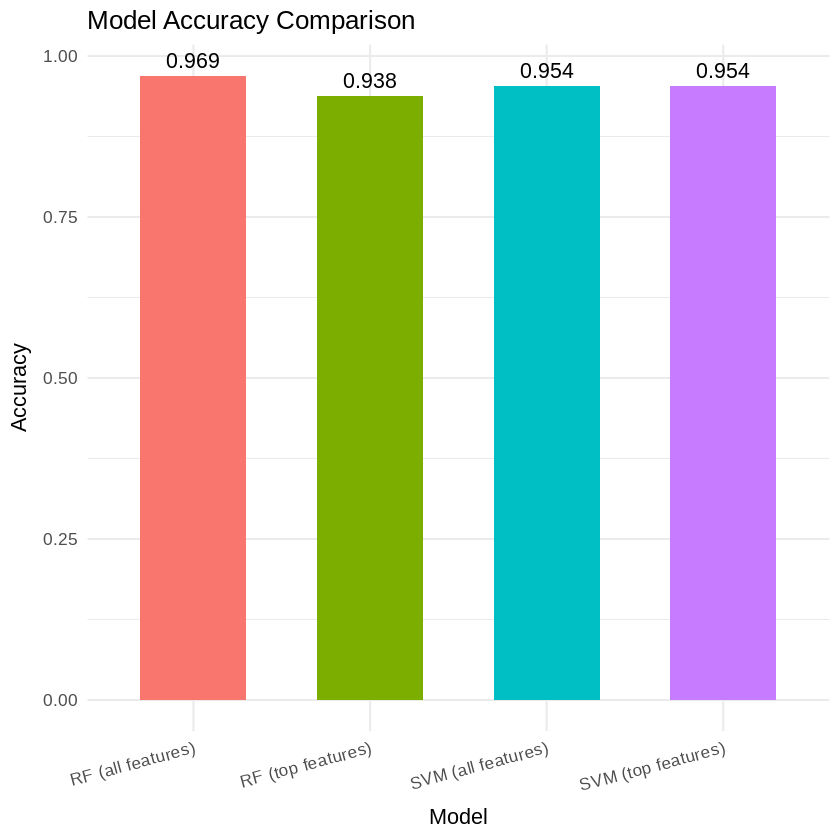

In [ ]:
p_acc <- ggplot(acc_table, aes(x = Model, y = Accuracy, fill = Model)) +
  geom_bar(stat = "identity", width = 0.6) +
  geom_text(aes(label = round(Accuracy, 3)), vjust = -0.5, size = 4.5) +
  labs(title = "Model Accuracy Comparison",
       x = "Model",
       y = "Accuracy") +
  theme_minimal(base_size = 13) +
  theme(axis.text.x = element_text(angle = 15, hjust = 1),
        legend.position = "none")
p_acc

In [ ]:
#save as PNG
ggsave("Model_Accuracy_Comparison.png", plot = p_acc, width = 8, height = 5, dpi = 300)

In [ ]:
# Save the results
write.csv(acc_table, "Accuracy_Comparison.csv", row.names = FALSE)
